In [1]:
!ls their_data

TMS_SCRIPT_2023JUL20.R
TMS_TRIAL_DATA_2023JUL20.csv
TMS_TRIAL_DICT_2023JUL20.csv


In [2]:
!cat their_data/TMS_TRIAL_DICT_2023JUL20.csv

COLUMN_LABEL,DESCRIPTION,VALUES
id,unique identification number assigned to each participant,integer between 1 and 108
randomization,randomly assigned treatment arm and order of intention,1 (R stimulation L intention first) or 2 (R stimulation R intention first) or 3 (L stimulation L intention first) or 4 (L stimulation R intention first) or 5 (S stimulation L intention first) or 6 (S stimulation R intention first)
tmsgroup,type of stimulation,1 (R stimulation) or 2 (L stimulation) or 3 (Sham stimulation)
condition,type of trial,experimental right (1) or control right (2) or experimental left (3) or control left (4)
trial,order of trials within a condition,integer from 1 to 500
reg,sum of 200 consecutive binary 0 or 1 digits within a trial,integer from 0 to 200


In [3]:
import pandas

tms_trial_data = pandas.read_csv("their_data/TMS_TRIAL_DATA_2023JUL20.csv")

In [4]:
tms_trial_data

,id,randomization,tmsgroup,condition,trial,reg
0,1,4,2,4,1,99
1,1,4,2,4,2,109
2,1,4,2,4,3,99
3,1,4,2,4,4,97
4,1,4,2,4,5,102
...,...,...,...,...,...,...
215995,108,4,2,1,496,98
215996,108,4,2,1,497,102
215997,108,4,2,1,498,101
215998,108,4,2,1,499,98


In [5]:
from collections import OrderedDict
import numpy as np

group_and_condition_to_trialdata = OrderedDict()

#gather the data for all of them
for group, group_easyname in [(1,"Rstim_Lfirst"),
                                              (2, "Rstim_Rfirst"),
                                              (3, "Lstim_Lfirst"),
                                              (4, "Lstim_Rfirst"),
                                              (5, "Sstim_Lfirst"),
                                              (6, "Sstim_Rfirst")]:
    group_and_condition_to_trialdata[group_easyname] = OrderedDict()
    for condition, condition_easyname in [(1, "expRight"),
                                          (2, "contRight"),
                                          (3, "expLeft"),
                                          (4, "contLeft")]:
        filtered_tms_data = tms_trial_data[(tms_trial_data["randomization"]==group)
                                           & (tms_trial_data["condition"]==condition)]
        trials_for_all_subjects = [] #gather the trials for all subjects into a list of lists
        subject_nums = set(filtered_tms_data["id"])
        for subject_num in sorted(subject_nums):
            data_for_subject = filtered_tms_data[filtered_tms_data["id"]==subject_num]
            #get the reg values, sorted in ascending order by trial number
            sorted_reg_values = np.array(data_for_subject["reg"])[np.argsort(data_for_subject["trial"])]            
            trials_for_all_subjects.append(sorted_reg_values)
        trials_for_all_subjects = np.array(trials_for_all_subjects)
        group_and_condition_to_trialdata[group_easyname][condition_easyname] = trials_for_all_subjects

Plot the trend in the effect for each condition (effect consists of "more ones")

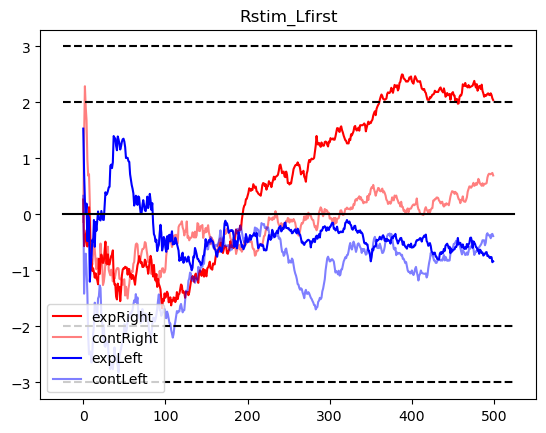

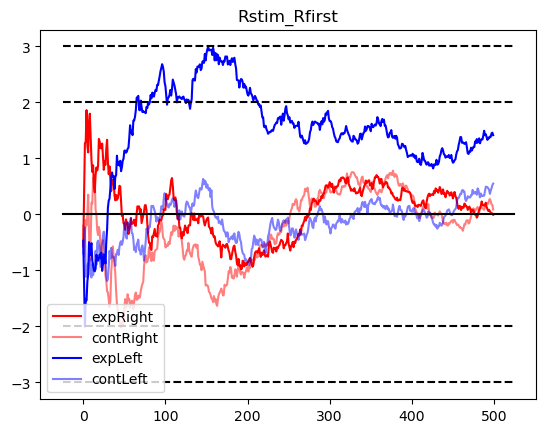

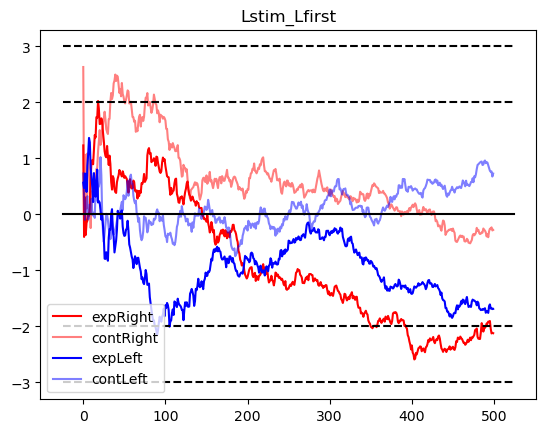

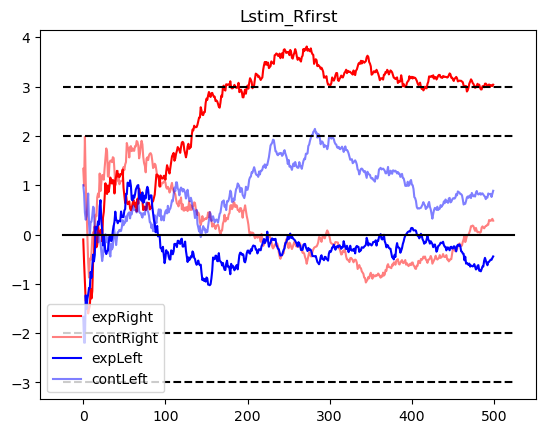

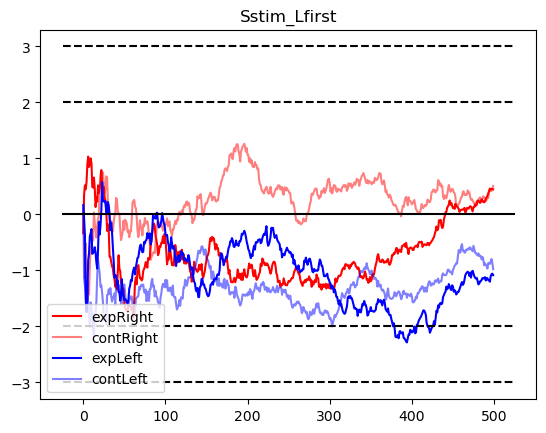

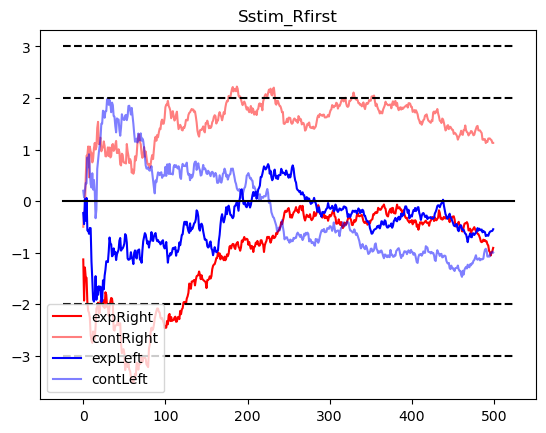

In [6]:
#plot to make sure
%matplotlib inline
from matplotlib import pyplot as plt

conditionname_to_color = {
    'expRight': 'red',
    'expLeft': 'blue',
    'contRight': 'red',
    'contLeft': 'blue'
}

conditionname_to_alpha = {
    'expRight': 1.0,
    'expLeft': 1.0,
    'contRight': 0.5,
    'contLeft': 0.5
}

for groupname in group_and_condition_to_trialdata:
    handles = []
    handle_labels = []
    for conditionname in group_and_condition_to_trialdata[groupname]:
        data = group_and_condition_to_trialdata[groupname][conditionname]
        handles.append(
         plt.plot(np.cumsum(np.sum(data-100, axis=0))/(np.sqrt(50)*np.sqrt(np.arange(500)+1)*np.sqrt(data.shape[0])),
                 color=conditionname_to_color[conditionname],
                 alpha=conditionname_to_alpha[conditionname])[0])
        handle_labels.append(conditionname)
    plt.legend(handles=handles, labels=handle_labels, loc=3)
    xlim = plt.xlim()
    plt.plot(xlim, [0,0], color="black")
    #plt.plot(xlim, [1,1], linestyle="--", color="black")
    plt.plot(xlim, [2,2], linestyle="--", color="black")
    plt.plot(xlim, [3,3], linestyle="--", color="black")
    #plt.plot(xlim, [-1,-1], linestyle="--", color="black")
    plt.plot(xlim, [-2,-2], linestyle="--", color="black")
    plt.plot(xlim, [-3,-3], linestyle="--", color="black")
    plt.title(groupname)
    plt.show()

Check device variance

In [7]:
#verify that the device variance is <= the theoretical expectation of 50
np.var(np.ravel(group_and_condition_to_trialdata["Lstim_Rfirst"]["contRight"][:,:]), axis=0)

49.05956365432099

Test for a decline effect within the Lstim_Rfirst_expRight group

In [37]:
import scipy.stats

#Do a permutation test to check for declining effect size

def best_test_across_thresh(vals, thresh_min, thresh_max, stepsize):
    min_pval = 1.0
    for thresh in range(thresh_min, thresh_max, stepsize):
        #Under the null hypothesis, the data should follow a Gaussian distribution, so a t-test
        # is justified (and has greater power than a mann-whitney test)
        pval = scipy.stats.ttest_ind(a=vals[:thresh], b=vals[thresh:], alternative='greater').pvalue
        #Out of curiousity we can also do a mannwhitney test that doesn't make assumptions about the
        # data distribution, although we would be implicitly validating the alternative hypothesis
        # if we felt it was necessary to use this test over a t-test, since the null hypothesis
        # is that there is no decline effect
        #pval = scipy.stats.mannwhitneyu(x=vals[:thresh],
        #                                y=vals[thresh:],
        #                                alternative='greater').pvalue
        min_pval = min(min_pval, pval)
    return min_pval

#We can also concatenate the Rfirst and Lfirst groups along the time dim in which case the p-value is highly significant,
# but the set of subjects changes so this would be confounded by any potential subject effect as well.
#vals_to_test_for_decline = np.concatenate([group_and_condition_to_trialdata["Lstim_Rfirst"]["expRight"],
#                                           group_and_condition_to_trialdata["Lstim_Lfirst"]["expRight"]], axis=1)
vals_to_test_for_decline = group_and_condition_to_trialdata["Lstim_Rfirst"]["expRight"]
print("t-test using a 50-50 split", scipy.stats.ttest_ind(a=np.mean(vals_to_test_for_decline,axis=0)[:250],
                                                        b=np.mean(vals_to_test_for_decline,axis=0)[250:],
                                                        alternative='greater').pvalue)

thresh_min = 150
thresh_max = 351
stepsize = 10
best_pval = best_test_across_thresh(np.mean(vals_to_test_for_decline, axis=0), thresh_min, thresh_max, stepsize)
print("raw pval finding best threshold to partition the groups", best_pval)
rng = np.random.RandomState(123)
n_perm = 1000
perm_pvals = []
for i in range(n_perm):
    if (i%100==0):
        print("Done", i)
    #test for a decline in the mean effect across all subjects
    perm_vals = np.mean(rng.permutation(vals_to_test_for_decline.transpose()).transpose(), axis=0)
    #perm_vals = rng.permutation(np.mean(vals_to_test_for_decline, axis=0))
    perm_pval = best_test_across_thresh(vals=perm_vals,
                                        thresh_min=thresh_min, thresh_max=thresh_max, stepsize=stepsize)
    perm_pvals.append(perm_pval)
perm_pvals = np.array(perm_pvals)
num_perm_less = np.sum(perm_pvals <= best_pval)
#pval of around 6% i.e. 6% that this effect was due to chance
print("permutation pval for raw pval relative to shuffled data:", (num_perm_less+1)/(n_perm+1))


t-test using a 50-50 split 0.013292820700504597
raw pval finding best threshold to partition the groups 0.012898934731176278
Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
permutation pval for raw pval relative to shuffled data: 0.06493506493506493


Investigate a subject effect

First plot the distribution of the effect for individual subjects

[-1.7455772684129451, -1.0814989597775857, -0.2719558787744806, -0.2403331021727968, -0.1075174404457249, -0.09486832980505137, 0.2719558787744806, 0.3099032106965012, 0.5565608681896347, 0.6704028639556964, 0.6830519745963699, 1.0941480704182591, 1.2965338406690354, 1.6380598279672203, 1.6380598279672203, 2.5487957940957133, 2.8397253388312045, 2.8839972260735616]


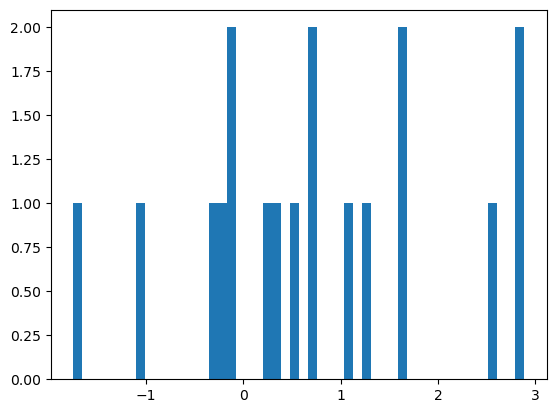

In [24]:
data = group_and_condition_to_trialdata["Lstim_Rfirst"]["expRight"]
per_subject_effectsize = np.sum(data-100, axis=1)/(np.sqrt(50)*np.sqrt(data.shape[1]))
print(sorted(per_subject_effectsize))
plt.hist(per_subject_effectsize, bins=50)
plt.show()

see if the effect in half of the data is predictive of the effect in the other half

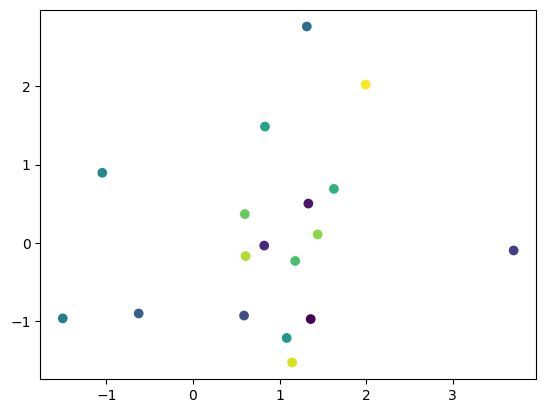

SignificanceResult(statistic=0.18954248366013074, pvalue=0.293450858549159)


In [38]:
%matplotlib inline
from matplotlib import pyplot as plt

data = group_and_condition_to_trialdata["Lstim_Rfirst"]["expRight"]
#data = group_and_condition_to_trialdata["Lstim_Lfirst"]["expLeft"]
per_subject_effectsize_slice1 = np.sum(data[:,::2]-100, axis=1)/(np.sqrt(50)*np.sqrt(data.shape[1]/2))
per_subject_effectsize_slice2 = np.sum(data[:,1::2]-100, axis=1)/(np.sqrt(50)*np.sqrt(data.shape[1]/2))
plt.scatter(per_subject_effectsize_slice1, per_subject_effectsize_slice2, c=np.arange(data.shape[0]))

plt.show()

print(scipy.stats.kendalltau(per_subject_effectsize_slice1, per_subject_effectsize_slice2))